In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [22]:
def run_randomforest(train_path, test_path, pred_path, current_rent='No', null_model='No', pca_data='No'):
    
    # Load the data
    
    data_train = pd.read_csv(train_path, index_col=False)
    data_test = pd.read_csv(test_path, index_col=False)
    data_pred = pd.read_csv(pred_path, index_col=False)
    
    # Create target and feature variables
    
    drop_list = ['Rent', 'RegionName', 'City', 'State']
    
    if current_rent in ['No', 'no', 0]:
        drop_list.append('Current Rent')
    if pca_data in ['Yes', 'yes', 1]:
        drop_list = ['Rent']
    
    if current_rent in ['No', 'no', 0]:
        train_X = data_train.drop(drop_list, axis=1)
        test_X = data_test.drop(drop_list, axis=1)
        pred_X = data_pred.drop(drop_list, axis=1)
    elif current_rent in ['Yes', 'yes', 1]:
        train_X = data_train.drop(drop_list, axis=1)
        test_X = data_test.drop(drop_list, axis=1)
        pred_X = data_pred.drop(drop_list, axis=1)
    else:
        raise ValueError('Enter Yes or No for current_rent parameter')
        
    print("current rent in data: ",current_rent)
    
    if null_model in ['No', 'no', 0]:
        train_X = train_X
        test_X = test_X
        pred_X = pred_X
    elif null_model in ['Yes', 'yes', 1]:
        train_X = np.array(train_X['Current Rent']).reshape(-1, 1)
        test_X = np.array(test_X['Current Rent']).reshape(-1, 1)
        pred_X= np.array(pred_X['Current Rent']).reshape(-1, 1)
    else:
        raise ValueError('Enter Yes or No for null_model parameter')
        
    print('null model: ',null_model)
    
    if pca_data in ['No', 'no', 0]:
        train_X = train_X.copy()
        test_X = test_X.copy()
        pred_X = pred_X.copy()
    if pca_data in ['Yes', 'yes', 1]:
        train_X = data_train.drop(drop_list, axis=1)
        test_X = data_test.drop(drop_list, axis=1)
        pred_X = data_pred.drop(drop_list, axis=1)
    
    train_y = data_train['Rent']
    test_y = data_test['Rent']
    pred_y = data_pred['Rent']
    # Load and fit model
    
    randomforest = RandomForestRegressor(random_state=42)
    randomforest.fit(train_X, train_y)
    
    print("\nWith default param the training error is : %.5f" % (1 - randomforest.score(train_X, train_y)))
    print("With default param the test error is: %.5f" % (1 - randomforest.score(test_X, test_y)))
    
    # Check cv score avg
    
    cv_score = cross_val_score(randomforest, train_X, train_y, cv=5)
    print('With default param, cv score average is : ', cv_score.mean(), '\n')
    
    # create y prediction
    
    y_pred = randomforest.predict(test_X)
    
    # show results with default param
    
    print("\nWith default param the r2 score is : %.5f" % r2_score(test_y, y_pred))
    print("With default param the mse is : %.5f" % mean_squared_error(test_y, y_pred))
    print("With default param the rmse is : %.5f" % (mean_squared_error(test_y, y_pred)**.5), '\n')
    
    # create parameters for grid search
    
    param_grid = dict()
    param_grid['max_features'] = [.30, .35, .40]
    param_grid['n_estimators'] = [650, 700, 750]
    param_grid['max_depth'] = [12, 14, 16]
    
    # run grid search
    
    grid_search = GridSearchCV(estimator = randomforest, param_grid = param_grid, scoring = 'r2', n_jobs = -1, cv = 5, return_train_score = True)
    grid_result = grid_search.fit(train_X, train_y)
    
    # rerun model with best param
    
    randomforest2 = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    randomforest2.fit(train_X, train_y)
    
    print("\nWith best param the training error is : %.5f" % (1 - randomforest2.score(train_X, train_y)))
    print("With best param the test error is: %.5f" % (1 - randomforest2.score(test_X, test_y)))
    
    # Check new cv score avg
    
    cv_score = cross_val_score(randomforest2, train_X, train_y, cv=5)
    print('With best param, cv score average is : ', cv_score.mean(), '\n')
    
    # create new y prediction
    
    y_new_pred = randomforest2.predict(test_X)
    
    # show new results with best param
    
    print("\nWith best param the r2 score is : %.5f" % r2_score(test_y, y_new_pred))
    print("With best param the mse is : %.5f" % mean_squared_error(test_y, y_new_pred))
    print("With best param the rmse is : %.5f" % (mean_squared_error(test_y, y_new_pred)**.5), '\n')
    
    # show feature importance
    
    importance = randomforest2.feature_importances_
    print(pd.DataFrame({'Feature Importance': importance, 'Feature': train_X.columns}).sort_values(by='Feature Importance', ascending=False))
    
    features = train_X.columns
    indices = np.argsort(importance)

    plt.figure(1, figsize=(8, 10), dpi=80)
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Imprtance')
    

## All feats, no current rent

current rent in data:  No
null model:  No

With default param the training error is : 0.03371
With default param the test error is: 0.28342
With default param, cv score average is :  0.7394660177892449 


With default param the r2 score is : 0.71658
With default param the mse is : 123759.29084
With default param the rmse is : 351.79439 


With best param the training error is : 0.03312
With best param the test error is: 0.29068
With best param, cv score average is :  0.7468866319754568 


With best param the r2 score is : 0.70932
With best param the mse is : 126930.65164
With best param the rmse is : 356.27328 

    Feature Importance                                  Feature
8             0.115191               Perc_commuters_over_45_min
13            0.111056        Perc_commuter_by_public_transport
2             0.107330                            median_income
6             0.084971                average_car_per_household
23            0.055310     employed_in_finance_information_p

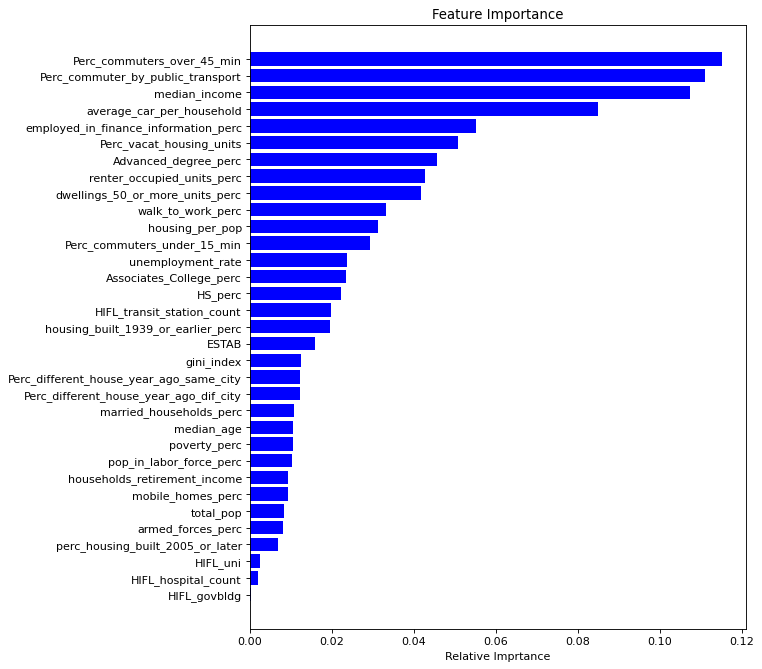

In [13]:
run_randomforest('TRAINDATAnewcols7.19_3year.csv', 'TESTDATAnewcols7.19_3year.csv', 'PREDICTDATAnewcols7.19_3year.csv')

## All feats and current rent

current rent in data:  1
null model:  No

With default param the training error is : 0.00768
With default param the test error is: 0.06260
With default param, cv score average is :  0.9434399418732159 


With default param the r2 score is : 0.93740
With default param the mse is : 27332.98293
With default param the rmse is : 165.32690 


With best param the training error is : 0.00839
With best param the test error is: 0.07374
With best param, cv score average is :  0.9378374420898747 


With best param the r2 score is : 0.92626
With best param the mse is : 32198.75139
With best param the rmse is : 179.44011 

    Feature Importance                                  Feature
0             0.606453                             Current Rent
7             0.054041                average_car_per_household
14            0.050919        Perc_commuter_by_public_transport
3             0.044091                            median_income
9             0.041805               Perc_commuters_over_45_min

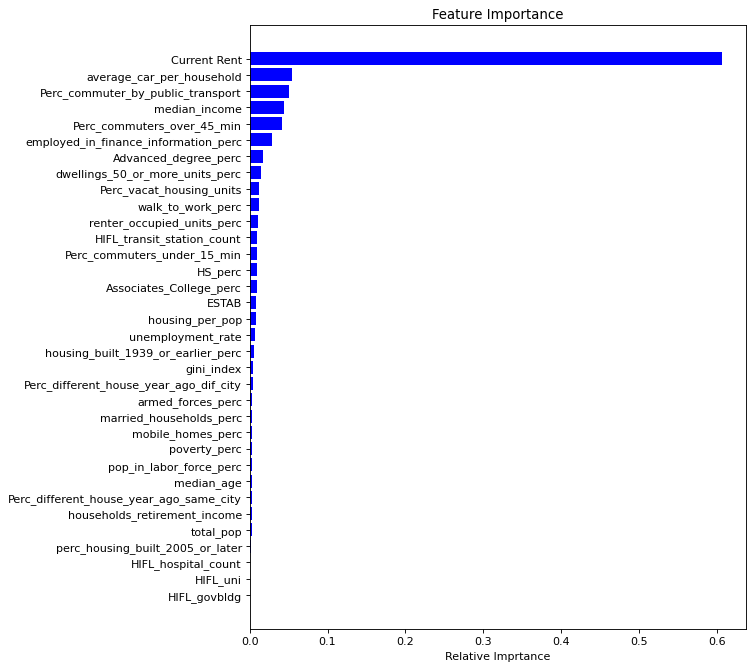

In [14]:
run_randomforest('TRAINDATAnewcols7.19_3year.csv', 'TESTDATAnewcols7.19_3year.csv', 'PREDICTDATAnewcols7.19_3year.csv', current_rent=1)

In [21]:
run_randomforest('TRAINDATAnewcols7.19_3year.csv', 'TESTDATAnewcols7.19_3year.csv', 'PREDICTDATAnewcols7.19_3year.csv', current_rent=1, null_model=1)

current rent in data:  1
null model:  1

With default param the training error is : 0.01841
With default param the test error is: 0.10245
With default param, cv score average is :  0.9010458728354873 


With default param the r2 score is : 0.89755
With default param the mse is : 44738.04720
With default param the rmse is : 211.51370 


With best param the training error is : 0.02000
With best param the test error is: 0.09981
With best param, cv score average is :  0.903147641879233 


With best param the r2 score is : 0.90019
With best param the mse is : 43583.96450
With best param the rmse is : 208.76773 



AttributeError: 'numpy.ndarray' object has no attribute 'columns'

current rent in data:  0
null model:  0

With default param the training error is : 0.02414
With default param the test error is: 0.21483
With default param, cv score average is :  0.8198670846508043 


With default param the r2 score is : 0.78517
With default param the mse is : 93806.56202
With default param the rmse is : 306.27857 


With best param the training error is : 0.02341
With best param the test error is: 0.20620
With best param, cv score average is :  0.8171864296861688 


With best param the r2 score is : 0.79380
With best param the mse is : 90041.68966
With best param the rmse is : 300.06947 

    Feature Importance Feature
2             0.314680       2
0             0.173656       0
17            0.096144      17
7             0.054279       7
4             0.033932       4
22            0.026452      22
8             0.023243       8
21            0.021896      21
6             0.021592       6
23            0.021241      23
20            0.020328      20
9           

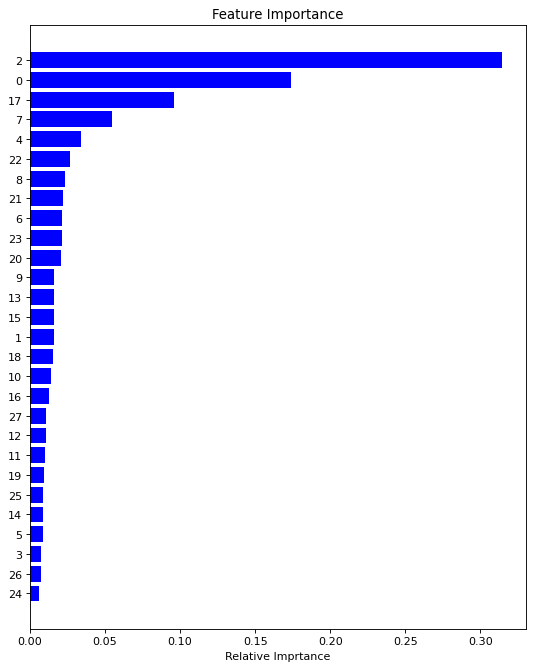

In [23]:
run_randomforest('TRAINDATAnewcols7.19_3yearPCApartial.csv', 'TESTDATAnewcols7.19_3yearPCApartial.csv', 'PREDICTDATAnewcols7.19_3yearPCApartial.csv', current_rent=0, null_model=0, pca_data=1)

In [ ]:
run_randomforest('TRAINDATAnewcols7.19_3yearPCApartial.csv', 'TESTDATAnewcols7.19_3yearPCApartial.csv', 'PREDICTDATAnewcols7.19_3yearPCApartial.csv', current_rent=0, null_model=0, pca_data=1)

current rent in data:  0
null model:  0

With default param the training error is : 0.04229
With default param the test error is: 0.35167
With default param, cv score average is :  0.6960241915016215 


With default param the r2 score is : 0.64833
With default param the mse is : 153562.26293
With default param the rmse is : 391.87021 


With best param the training error is : 0.03993
With best param the test error is: 0.34220
With best param, cv score average is :  0.6979333292934992 


With best param the r2 score is : 0.65780
With best param the mse is : 149424.99363
With best param the rmse is : 386.55529 

    Feature Importance Feature
2             0.302895       2
0             0.127371       0
19            0.048240      19
4             0.043482       4
17            0.033161      17
8             0.030564       8
30            0.028358      30
26            0.026474      26
9             0.025999       9
20            0.024839      20
22            0.022951      22
1         

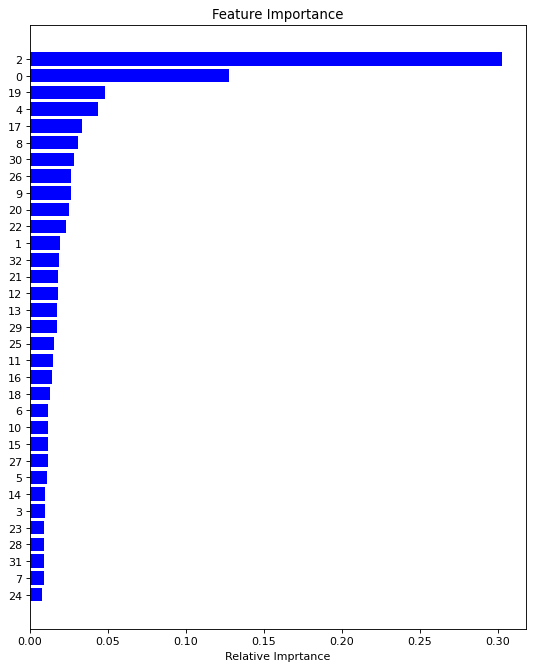

In [24]:
run_randomforest('TRAINDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv', 'TESTDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv', 'PREDICTDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv', current_rent=0, null_model=0, pca_data=1)